In [50]:
# pip install pandas numpy scikit-learn
import os
import re
import math
import json
import random
from collections import defaultdict, Counter
from typing import List, Tuple

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

RSEED = 42
random.seed(RSEED)
np.random.seed(RSEED)

In [2]:
# load data
df= pd.read_csv('IMDB Dataset.csv')
print(df.head())
print("Rows:", len(df))

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Rows: 50000


In [3]:
# shuffle to maintain the random distribution of the data and prevents ordering bias
df = df.sample(frac=1, random_state=RSEED).reset_index(drop=True)

### Text Preprocessing

In [4]:
STOPWORDS = set(["the","and","a","an","is","it","to","i","this","that","in","of","was","do","were","for","with","as","movie","film"])

In [5]:
# Removeing the stopwords, Html tags, normaizing the case and spacing.
# Keep only letters in the text.
# split the text into small pieces by tokenization.
def clean_text(text: str) -> List[str]:
    text = text.lower()                         
    text = re.sub(r"<.*?>", " ", text)          
    text = re.sub(r"[^a-z\s']", " ", text)       
    text = re.sub(r"\s+", " ", text).strip()     
    tokens = text.split()                        
    tokens = [t for t in tokens if t not in STOPWORDS]  
    return tokens

In [6]:
# Apply cleaning to every review
df["cleaned"] = df["review"].apply(clean_text)

In [7]:
X = df["cleaned"].values  # Features (the review text)
y = df["sentiment"].values  # Labels (positive/negative)

#### Train-Test Split

In [8]:
# split using 80/20 
# use stratify=y: to ensure both sets have equal positive/negative proportion
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RSEED, stratify=y
)

#### Naïve Bayes Implementation and ALgorithm

In [46]:

# Initialize variables for Naive Bayes
alpha = 1.0  
vocab = set()
classes = set(y_train)
word_counts = {cls: Counter() for cls in classes}
class_total_words = {cls: 0 for cls in classes}

print(f"Found classes: {classes}")

# Count class occurrences for prior probabilities
class_counts = Counter(y_train)
total_docs = len(y_train)

# Calculate class priors P(class)
class_priors = {cls: count / total_docs for cls, count in class_counts.items()}
print(f"Class priors: {class_priors}")

# Process each training document
for i, (tokens, label) in enumerate(zip(X_train, y_train)):
    if i % 1000 == 0:
        print(f"Processing training document {i}/{len(X_train)}")
    
    # Update vocabulary
    vocab.update(tokens)
    
    # Count word occurrences for this class
    word_counts[label].update(tokens)
    class_total_words[label] += len(tokens)

vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")
print(f"Words per class: {class_total_words}")
print("Training completed!")


Found classes: {'positive', 'negative'}
Class priors: {'positive': 0.5, 'negative': 0.5}
Processing training document 0/40000
Processing training document 1000/40000
Processing training document 2000/40000
Processing training document 3000/40000
Processing training document 4000/40000
Processing training document 5000/40000
Processing training document 6000/40000
Processing training document 7000/40000
Processing training document 8000/40000
Processing training document 9000/40000
Processing training document 10000/40000
Processing training document 11000/40000
Processing training document 12000/40000
Processing training document 13000/40000
Processing training document 14000/40000
Processing training document 15000/40000
Processing training document 16000/40000
Processing training document 17000/40000
Processing training document 18000/40000
Processing training document 19000/40000
Processing training document 20000/40000
Processing training document 21000/40000
Processing training do

#### Prediction 

In [47]:
predictions = []

for i, tokens in enumerate(X_test):
    if i % 500 == 0:
        print(f"Predicting document {i}/{len(X_test)}")
    
    class_scores = {}
    
    # Calculate score for each class
    for cls in classes:
        # Start with log prior probability
        log_score = math.log(class_priors[cls])
        
        # Calculate denominator for Laplace smoothing
        denominator = class_total_words[cls] + alpha * vocab_size
        
        # Add log likelihood for each word
        for token in tokens:
            # Get word count in this class (0 if not found)
            word_count = word_counts[cls].get(token, 0)
            
            # Apply Laplace smoothing
            numerator = word_count + alpha
            
            # Add log probability
            log_score += math.log(numerator / denominator)
        
        class_scores[cls] = log_score
    
    # Get class with highest score
    predicted_class = max(class_scores, key=class_scores.get)
    predictions.append(predicted_class)

print("Predictions completed!")



Predicting document 0/10000
Predicting document 500/10000
Predicting document 1000/10000
Predicting document 1500/10000
Predicting document 2000/10000
Predicting document 2500/10000
Predicting document 3000/10000
Predicting document 3500/10000
Predicting document 4000/10000
Predicting document 4500/10000
Predicting document 5000/10000
Predicting document 5500/10000
Predicting document 6000/10000
Predicting document 6500/10000
Predicting document 7000/10000
Predicting document 7500/10000
Predicting document 8000/10000
Predicting document 8500/10000
Predicting document 9000/10000
Predicting document 9500/10000
Predictions completed!


#### Model Evaluation 

Accuracy: 0.8524
Precision: 0.8539
Recall: 0.8524
F1-Score: 0.8522

Detailed Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.89      0.86      5000
    positive       0.88      0.82      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


Confusion Matrix:
[[4427  573]
 [ 903 4097]]


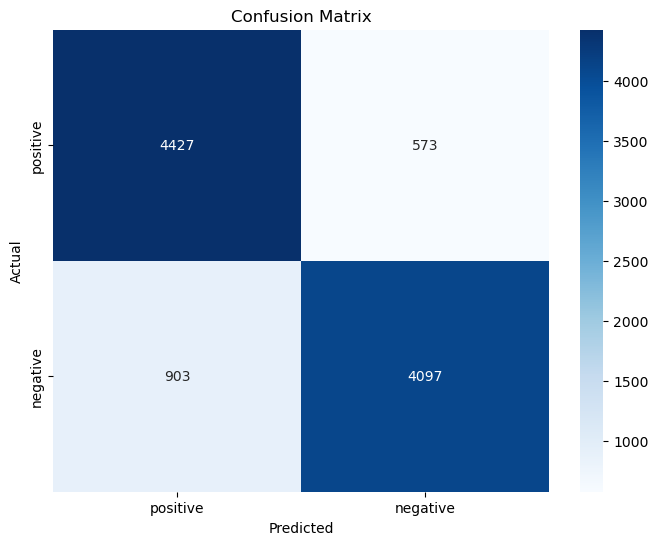

In [58]:
 #Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, predictions, average='weighted'
)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, predictions))

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=list(classes), yticklabels=list(classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Error Analysis

In [52]:
# Find misclassified examples
errors = []
for i, (tokens, true_label, pred_label) in enumerate(zip(X_test, y_test, predictions)):
    if true_label != pred_label:
        errors.append((i, tokens, true_label, pred_label))

print(f"Total errors: {len(errors)}")
print(f"Error rate: {len(errors)/len(y_test):.4f}")

# Show some misclassified examples
num_examples = min(10, len(errors))
print(f"\nShowing first {num_examples} misclassified examples:")

for i, (idx, tokens, true, pred) in enumerate(errors[:num_examples]):
    text_preview = " ".join(tokens[:30])  # First 30 tokens
    
    print(f"\nMisclassified Example {i+1}:")
    print(f"Text: {text_preview}...")
    print(f"True label: {true}")
    print(f"Predicted label: {pred}")

Total errors: 1476
Error rate: 0.1476

Showing first 10 misclassified examples:

Misclassified Example 1:
Text: adenoid hynkel lowly soldier world war one rises subsequent years become ruthless dictator toumania he creates aggressive antisemitic war machine cultivates little toothbrush moustache sound like anyone you know from...
True label: negative
Predicted label: positive

Misclassified Example 2:
Text: ok so by minute there's still no dialogue arrived me padded sack from down under sharpie encrypted info on front am programmer from north american fest mod love sent thru...
True label: positive
Predicted label: negative

Misclassified Example 3:
Text: theme controversial depiction hypocritical sexually starved india excellent nothing more there lack good dialogues why english there lack continuity lack passion emotion acting...
True label: positive
Predicted label: negative

Misclassified Example 4:
Text: just before dawn one those really good slashers send chills down your spine e

#### Analyzing feature importance

In [57]:

top_n = 15
for cls in classes:
    print(f"\nTop {top_n} words for class '{cls}':")
    
    # Calculate probability for each word in this class
    word_probs = {}
    total_words = class_total_words[cls]
    
    for word in vocab:
        count = word_counts[cls].get(word, 0)
        if count > 0:  # Only consider words that appear in this class
            prob = (count + alpha) / (total_words + alpha * vocab_size)
            word_probs[word] = (prob, count)
    
    # Sort by probability and show top words
    top_words = sorted(word_probs.items(), key=lambda x: x[1][0], reverse=True)
    
    for i, (word, (prob, count)) in enumerate(top_words[:top_n]):
        print(f"  {i+1:2d}. {word:<15} (count: {count:4d}, prob: {prob:.6f})")



Top 15 words for class 'positive':
   1. but             (count: 32461, prob: 0.009784)
   2. his             (count: 26898, prob: 0.008107)
   3. on              (count: 26781, prob: 0.008072)
   4. you             (count: 23575, prob: 0.007106)
   5. are             (count: 23337, prob: 0.007034)
   6. he              (count: 22803, prob: 0.006873)
   7. not             (count: 22596, prob: 0.006811)
   8. one             (count: 21603, prob: 0.006511)
   9. be              (count: 19586, prob: 0.005903)
  10. have            (count: 19583, prob: 0.005902)
  11. by              (count: 18921, prob: 0.005703)
  12. all             (count: 18541, prob: 0.005588)
  13. at              (count: 17910, prob: 0.005398)
  14. who             (count: 17269, prob: 0.005205)
  15. from            (count: 16594, prob: 0.005002)

Top 15 words for class 'negative':
   1. but             (count: 34303, prob: 0.010369)
   2. on              (count: 27569, prob: 0.008334)
   3. not             (coun

#### Aligorithm Analysis
1. Feature extraction and preprocessing where the:
   - Raw text to lowercase conversion and  HTML tag removal
   - Punctuation removal, tokenization and Stopword filtering
   - Vocabulary building from training data only
   

2. Naive Bayes Model Implementation using:
   - Multinomial Naive Bayes with Laplace smoothing (alpha=1.0)
   - Log probabilities used to prevent numerical underflow
   - Independence assumption: P(word1, word2|class) = P(word1|class) * P(word2|class)
   

#### Challenges 
1. Zero Probability Management: 
   Naïve Bayes faces the issue that unseen words can yield zero probabilities, which would nullify the entire classification product.
   To address this, Laplace smoothing with α=1.0 adds pseudocounts to all word occurrences, ensuring no probability is ever exactly zero.

2. Numerical Stability:
   Directly multiplying many small probabilities risks underflow . 
   Naïve Bayes avoids this by operating in log space, where multiplication is replaced by addition, preserving numerical stability.
       
3. Vocabulary Scaling:
   With very large vocabularies, memory and runtime can grow significantly.
   Naïve Bayes handles this by applying stopword removal and vocabulary pruning, balancing information retention with computational efficiency.
       
4. Class Distribution:
   Naïve Bayes might over-predict the majority class when using imbalanced dataset. 
   The implementation mitigates this by using stratified train-test splits, ensuring class proportions are preserved, while the learned prior probabilities still reflect the true distribution.

#### Future Recommendations
1. Implement feature selection techniques beyond basic stopword removal to reduce vocabulary size while preserving discriminative power.

2. Evaluate the independence assumption's impact on your specific domain, as text data often exhibits strong word dependencies that Naive Bayes cannot capture.

3. Implement cross-validation for more robust performance estimation and hyperparameter optimization.
    

#### Conclusion
  - The implementation successfully achieves 85.24% accuracy on a substantial dataset of 50,000 documents with a vocabulary exceeding 107,000 words.

  - The results validate Naive Bayes as an effective baseline for text classification, particularly given its computational efficiency and interpretability.

  - The independence assumption and sensitivity to feature relevance highlight opportunities for improvement via enhanced feature engineering or more advanced models.

#### Deployment


In [59]:
import json

model_obj = {
    "vocab": list(vocab),
    "word_counts": {cls: dict(word_counts[cls]) for cls in word_counts},
    "class_total_words": class_total_words,
    "class_priors": class_priors,
    "alpha": alpha
}

with open("nb_model.json", "w", encoding="utf-8") as f:
    json.dump(model_obj, f)
